Lambda School Data Science

*Unit 2, Sprint 2, Module 4*

---

# Classification Metrics

## Assignment
- [x] If you haven't yet, [review requirements for your portfolio project](https://lambdaschool.github.io/ds/unit2), then submit your dataset.
- [ ] Plot a confusion matrix for your Tanzania Waterpumps model.
- [ ] Continue to participate in our Kaggle challenge. Every student should have made at least one submission that scores at least 70% accuracy (well above the majority class baseline).
- [ ] Submit your final predictions to our Kaggle competition. Optionally, go to **My Submissions**, and _"you may select up to 1 submission to be used to count towards your final leaderboard score."_
- [ ] Commit your notebook to your fork of the GitHub repo.
- [ ] Read [Maximizing Scarce Maintenance Resources with Data: Applying predictive modeling, precision at k, and clustering to optimize impact](http://archive.is/DelgE), by Lambda DS3 student Michael Brady. His blog post extends the Tanzania Waterpumps scenario, far beyond what's in the lecture notebook.


## Stretch Goals

### Reading

- [Attacking discrimination with smarter machine learning](https://research.google.com/bigpicture/attacking-discrimination-in-ml/), by Google Research, with  interactive visualizations. _"A threshold classifier essentially makes a yes/no decision, putting things in one category or another. We look at how these classifiers work, ways they can potentially be unfair, and how you might turn an unfair classifier into a fairer one. As an illustrative example, we focus on loan granting scenarios where a bank may grant or deny a loan based on a single, automatically computed number such as a credit score."_
- [Notebook about how to calculate expected value from a confusion matrix by treating it as a cost-benefit matrix](https://github.com/podopie/DAT18NYC/blob/master/classes/13-expected_value_cost_benefit_analysis.ipynb)
- [Visualizing Machine Learning Thresholds to Make Better Business Decisions](https://blog.insightdatascience.com/visualizing-machine-learning-thresholds-to-make-better-business-decisions-4ab07f823415)


### Doing
- [ ] Share visualizations in our Slack channel!
- [ ] RandomizedSearchCV / GridSearchCV, for model selection. (See module 3 assignment notebook)
- [ ] Stacking Ensemble. (See module 3 assignment notebook)
- [ ] More Categorical Encoding. (See module 2 assignment notebook)

In [1]:
%%capture
import sys

# If you're on Colab:
if 'google.colab' in sys.modules:
    DATA_PATH = 'https://raw.githubusercontent.com/LambdaSchool/DS-Unit-2-Kaggle-Challenge/master/data/'
    !pip install category_encoders==2.*

# If you're working locally:
else:
    DATA_PATH = '/Users/keila/Documents/Lambda/Units_Git/DS-Unit-2-Kaggle-Challenge/data/'

In [2]:
from category_encoders import OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, plot_confusion_matrix, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

import matplotlib.pyplot as plt

import numpy as np
import pandas as pd

# For Assignment

## Wrangle Data

In [44]:
def wrangle(fm_path, tv_path = None):
    # Import CSV files
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                   na_values = [0, -2.000000e-08],
                                   parse_dates = ['construction_year', 'date_recorded']),
                       pd.read_csv(tv_path)).set_index('id')
       
        # Add new binary target
        df['needs_repair'] = (df['status_group'] != 'functional').astype(int)
    
        # Drop old target
        df.drop(columns='status_group', inplace=True)
        
    else:
        df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], 
                     parse_dates = ['construction_year', 'date_recorded']).set_index('id')
    
    # Feature engineering (Credit: Mena)
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year
    
    # Drop constant and repeated columns
    df.drop(columns = ['recorded_by', 'extraction_type_group', 'extraction_type_class',
                       'quantity_group','date_recorded', 'construction_year', 'payment',
                       'source', 'waterpoint_type_group', 'scheme_management'], 
            inplace=True)
    
    # Drop columns with high % of NaN values
    df.dropna(axis = 1, thresh = len(df) * 0.65, inplace = True)
    
    # Columns where zeroes should be null values (Credit: Samuel E)
    cols_w_0s = ['longitude', 'latitude', 'gps_height']
    for col in cols_w_0s:
        df[col] = df[col].replace(0, np.nan)
    
    return df

In [45]:
train = wrangle(fm_path = DATA_PATH+'waterpumps/train_features.csv', 
                tv_path = DATA_PATH+'waterpumps/train_labels.csv')

In [46]:
train.shape

(59399, 27)

## Split Data

In [47]:
# Split into FM and TV
target = 'needs_repair'
y = train[target]
X = train.drop(columns = target)

# Do train validate split to make confusion matrix
X_train , X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

## Establish Baseline

In [48]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.5425829668132747


## Build Model

In [101]:
model = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(random_state = 42,
                                                n_estimators = 277,
                                                max_depth = 22,
                                                max_samples = 0.5,
                                                max_features = 6,
                                                n_jobs = -1))

model.fit(X_train, y_train);

## Check Metrics

**Accuracy**

In [102]:
print('Training Accuracy:', model.score(X_train, y_train))
print('Validation Accuracy:', model.score(X_val, y_val)) 

Training Accuracy: 0.9579747048549001
Validation Accuracy: 0.8248316498316498


**Confusion Matrix**

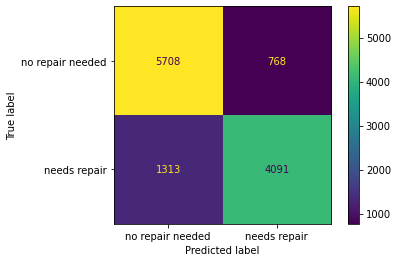

In [103]:
plot_confusion_matrix(
    model,
    X_val, 
    y_val,
    values_format='.0f',
    display_labels=['no repair needed', 'needs repair']
);

In [104]:
print(classification_report(y_val,
                            model.predict(X_val),
                            target_names=['no repair needed', 'needs repair']))

                  precision    recall  f1-score   support

no repair needed       0.81      0.88      0.85      6476
    needs repair       0.84      0.76      0.80      5404

        accuracy                           0.82     11880
       macro avg       0.83      0.82      0.82     11880
    weighted avg       0.83      0.82      0.82     11880



## Tune Model

In [82]:
# Set up estimator
estimator = make_pipeline(OrdinalEncoder(),
                          SimpleImputer(),
                          RandomForestClassifier(random_state = 42,
                                                 max_samples = 0.5,
                                                 n_estimators = 277))

# Want to find best randomforestclassifier max_depth
params = {'randomforestclassifier__max_depth': range(2, 42, 2)}

# Run RandomizedSearchCV
model_rs = RandomizedSearchCV(estimator, 
                               param_distributions = params,
                               n_iter = 5,
                               cv = 5,
                               n_jobs = -1,
                               verbose = 1)

# Fit randomizedsearch to data
model_rs.fit(X_train, y_train);

Fitting 5 folds for each of 5 candidates, totalling 25 fits


In [83]:
model_rs.best_score_

0.8187673833108171

In [84]:
model_rs.best_params_

{'randomforestclassifier__max_depth': 22}

# For Kaggle

## Wrangle Data

In [3]:
def wrangle(fm_path, tv_path = None):
    # Import CSV files
    if tv_path:
        df = pd.merge(pd.read_csv(fm_path, 
                                   na_values = [0, -2.000000e-08],
                                   parse_dates = ['construction_year', 'date_recorded']),
                       pd.read_csv(tv_path)).set_index('id')
    
    else:
        df = pd.read_csv(fm_path, na_values=[0, -2.000000e-08], 
                     parse_dates = ['construction_year', 'date_recorded']).set_index('id')
    
    # Feature engineering (Credit: Mena)
    df['pump_age'] = df['date_recorded'].dt.year - df['construction_year'].dt.year
    
    # Drop constant and repeated columns
    df.drop(columns = ['recorded_by', 'extraction_type_group', 'extraction_type_class',
                       'quantity_group','date_recorded', 'construction_year', 'payment',
                       'source', 'waterpoint_type_group', 'scheme_management'], 
            inplace=True)
    
    # Drop columns with high % of NaN values
    df.dropna(axis = 1, thresh = len(df) * 0.65, inplace = True)
    
    # Columns where zeroes should be null values (Credit: Samuel E)
    cols_w_0s = ['longitude', 'latitude', 'gps_height']
    for col in cols_w_0s:
        df[col] = df[col].replace(0, np.nan)
    
    return df

In [4]:
train = wrangle(fm_path = DATA_PATH+'waterpumps/train_features.csv', 
                tv_path = DATA_PATH+'waterpumps/train_labels.csv')
train.head()

,funder,gps_height,installer,longitude,latitude,wpt_name,basin,subvillage,region,region_code,...,management_group,payment_type,water_quality,quality_group,quantity,source_type,source_class,waterpoint_type,status_group,pump_age
id,,,,,,,,,,,,,,,,,,,,,
69572.0,Roman,1390.0,Roman,34.938093,-9.856322,none,Lake Nyasa,Mnyusi B,Iringa,11,...,user-group,annually,soft,good,enough,spring,groundwater,communal standpipe,functional,12.0
8776.0,Grumeti,1399.0,GRUMETI,34.698766,-2.147466,Zahanati,Lake Victoria,Nyamara,Mara,20,...,user-group,never pay,soft,good,insufficient,rainwater harvesting,surface,communal standpipe,functional,3.0
34310.0,Lottery Club,686.0,World vision,37.460664,-3.821329,Kwa Mahundi,Pangani,Majengo,Manyara,21,...,user-group,per bucket,soft,good,enough,dam,surface,communal standpipe multiple,functional,4.0
67743.0,Unicef,263.0,UNICEF,38.486161,-11.155298,Zahanati Ya Nanyumbu,Ruvuma / Southern Coast,Mahakamani,Mtwara,90,...,user-group,never pay,soft,good,dry,borehole,groundwater,communal standpipe multiple,non functional,27.0
19728.0,Action In A,NaN,Artisan,31.130847,-1.825359,Shuleni,Lake Victoria,Kyanyamisa,Kagera,18,...,other,never pay,soft,good,seasonal,rainwater harvesting,surface,communal standpipe,functional,NaN


In [5]:
train.shape

(59399, 27)

## Split Data

In [12]:
# Split into FM and TV
target = 'status_group'
y_train = train[target]
X_train = train.drop(columns = target)

## Establish Baseline

In [13]:
print('Baseline Accuracy:', y_train.value_counts(normalize = True).max())

Baseline Accuracy: 0.5430899510092763


## Build Model

In [14]:
rf_model = make_pipeline(OrdinalEncoder(),
                         SimpleImputer(),
                         RandomForestClassifier(random_state = 42,
                                                n_estimators = 277,
                                                max_depth = 35,
                                                max_samples = 0.5,
                                                max_features = 4,
                                                n_jobs = -1))

rf_model.fit(X_train, y_train);

**Check Scores**

In [15]:
cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv = 10, n_jobs = -1)

print('CV score RandomForestClassifier')
print(cv_scores_rf)
print('Mean CV accuracy score:', cv_scores_rf.mean())
print('STD CV accuracy score:', cv_scores_rf.std())

CV score RandomForestClassifier
[0.81548822 0.82087542 0.80976431 0.80824916 0.82087542 0.80824916
 0.81296296 0.81060606 0.8043771  0.81781445]
Mean CV accuracy score: 0.812926225832439
STD CV accuracy score: 0.0053764070638947364


## Make a Submission

In [17]:
# Read test_features.csv 
test = wrangle(DATA_PATH+'waterpumps/test_features.csv')

# Make predictions on test data
y_pred = rf_model.predict(test)

# Put predictions in necessary format for submission to Kaggle
submission = pd.DataFrame({'status_group':y_pred}, index = test.index)

# Save csv with predictions in proper format
submission.to_csv('02_18_2021_submission.csv')

## Communicate Results

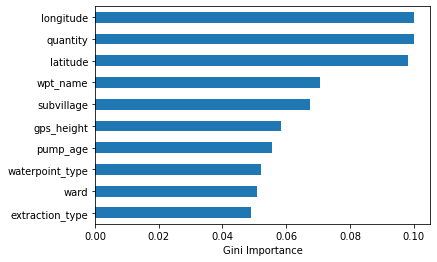

In [16]:
importances = rf_model.named_steps['randomforestclassifier'].feature_importances_

feat_names = X_train.columns

pd.Series(importances, index = feat_names).sort_values().tail(10).plot(kind = 'barh')
plt.xlabel('Gini Importance');